<h1 style="font-weight: bold; text-align: center;">Preprocessing - Pipeline</h1>

---

<h1>1 - Notebook Setup</h1>

<h2>1.1 - Imports</h2>

In [27]:
# NLP
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from autocorrect import Speller
from string import punctuation

import nltk

# visualization
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import tqdm

# data manipulation
from pathlib import Path

import pandas as pd
import os
import re

# Download NLP dependencies
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package stopwords to /home/brain-
[nltk_data]     matheus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/brain-
[nltk_data]     matheus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /home/brain-
[nltk_data]     matheus/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

<h2>1.2 - Dataset path</h2>

In [2]:
try:
    from google.colab import drive 
    drive.mount('/content/gdrive')
    df_path = Path('/content/gdrive/MyDrive/')
    figure_path = Path('/content')
    ENV = 'Google Colab'
except Exception as error:
    df_path = Path(os.getcwd().replace('notebooks', 'data/raw'))
    figure_path = Path(os.getcwd().replace('notebooks', 'figures'))
    ENV = 'Local Machine'

print(f'[\033[1;33mENVIRONMENT\033[0m]: {ENV}')
print(f'Dataset located in {df_path}')

[ENVIRONMENT]: Local Machine
Dataset located in /home/brain-matheus/Matheus/ChatBot/data/raw


<h1>2 - Dataset</h1>

<h2>2.1 - Loading dataset</h2>

In [12]:
data_frame = pd.read_csv(df_path.joinpath('chatbot_dataset.csv'), encoding='utf-8', delimiter=",", on_bad_lines='skip')

<h3>2.1.1 - Converting all rows in strings</h3>

In [13]:
data_frame['question'] = data_frame['question'].apply(lambda row: str(row))
data_frame['answer'] = data_frame['answer'].apply(lambda row: str(row))

In [14]:
data_frame

,Unnamed: 0,question,answer
0,0,Who did the first work generally recognized as...,Warren McCulloch and Walter Pitts (1943).
1,1,What sources was drawn on the formation of the...,knowledge of the basic physiology and function...
2,2,Who created the Hebbian learning rule?,Donald Hebb (1949).
3,3,When the first neural network is built?,1950.
4,4,What is the first neural network called?,The SNARC.
...,...,...,...
4348,4348,How do you treat a snake bite?,While waiting for medical help: 1)Move the per...
4349,4349,How do you treat a animal bite?,1)Wash the wound with soap and warm water. 2)G...
4350,4350,What to do if someone is Drowning?,1)Place your ear next to the person's mouth an...
4351,4351,How to give CPR??,"1)For an adult or child, place the heel of one..."


In [15]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4353 entries, 0 to 4352
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4353 non-null   int64 
 1   question    4353 non-null   object
 2   answer      4353 non-null   object
dtypes: int64(1), object(2)
memory usage: 102.1+ KB


<h2>2.2 - Cleaning text</h2>

<h3>2.2.1 - Creating a new dataset of cleaned data</h3>

In [569]:
cleaned_dataset = {'question': [], 'answers': []}

<h3>2.2.2 - 'Question' column</h3>

<h4>2.2.2.1 - Defining stop words</h4>

In [570]:
cleaned_dataset['question'].clear()
chars_filter = re.compile(pattern=r'''[.]*[(”?,:;"'“*)ºª!.-]+[.]*''')

unwanted_chars = [
    '\'', 
    '\"',
    '/p',
    'ª',
    'º',
    '.',
    '!',
    '?',
    ',',
    ';',
    ':',
    '-',
    '\'',
    '!!',
    '``',
    '"'
    ]

unwanted_words = [
    '\'s',
    "n't",
    '\'m',
    '\'ll',
    '\'re',
    'zzz',
    'b'
]

replacement = {
    'bluedog123': 'blue dog 123',
    'csp': 'content security policy',
    'cant': 'can not',
    'zerosum': 'zero sum',
    'itll': 'it will',
    'ii': '2',
    'isnt': 'is not',
    'ill': 'i will',
    'id': 'i would',
    'im': 'i am',
    'ive': 'i have',
    'hes': 'he is',
    'shes': 'she is',
    'humanlevel': 'human level',
    'al': 'artificial inteligence',
    'ai': 'artificial inteligence',
    'funnylooking': 'funny looking'
}

stop_words = set(stopwords.words('english') + list(punctuation) + list(unwanted_chars) + list (unwanted_words))

In [571]:
def plotWordCloud(data_tokenized):
    allWordsInRows = data_tokenized[:][:]
    allWords = []

    for wordsRow in allWordsInRows:
        allWords.extend(wordsRow)

    frequencies = nltk.FreqDist(allWords)
    sorted(frequencies,key=frequencies.__getitem__, reverse=True)

    wordcloud = WordCloud().generate_from_frequencies(frequencies)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

<h4>2.2.2.2 - Tokenizing 'Question' column</h4>

In [572]:
question_token = []
new_sentence = []

for row in tqdm.tqdm(iterable=data_frame['question'], desc='Tokening "Question" column..'):
    # normalizing text
    sentence = row.strip().lower()
    # removing stop words
    new_sentence.clear()
    for word in sentence.split(' '):
        curr_word_filter = chars_filter.search(string=word)
        while curr_word_filter:
            word = word.replace(curr_word_filter.group(0), '')
            curr_word_filter = chars_filter.search(string=word)
        if word in replacement:
            word = replacement[word].split(' ')
        if not isinstance(word, list):
            word = [word]
        for w in word:
            if w not in stop_words:
                new_sentence.append(w)
    # checking if a sentence is
    # empty
    if not len(new_sentence):
        new_sentence.append('<empty>')
    # saving new sentence
    question_token.append(new_sentence.copy())
    cleaned_dataset['question'].append(' '.join(new_sentence))

Tokening "Question" column..: 100%|██████████| 4353/4353 [00:00<00:00, 121928.42it/s]


<h4>2.2.2.3 - Counting fequency of words</h4>

In [573]:
question_freq_words = {}

for token in tqdm.tqdm(iterable=question_token, desc='Counting frequency of words..'):
    for word in token:
        if word not in question_freq_words:
            question_freq_words[word] = 0
        question_freq_words[word] += 1

# sorting by frequency
question_freq_words = dict(sorted(question_freq_words.items(), key=lambda x: x[1], reverse=True))

Counting frequency of words..: 100%|██████████| 4353/4353 [00:00<00:00, 980126.98it/s]


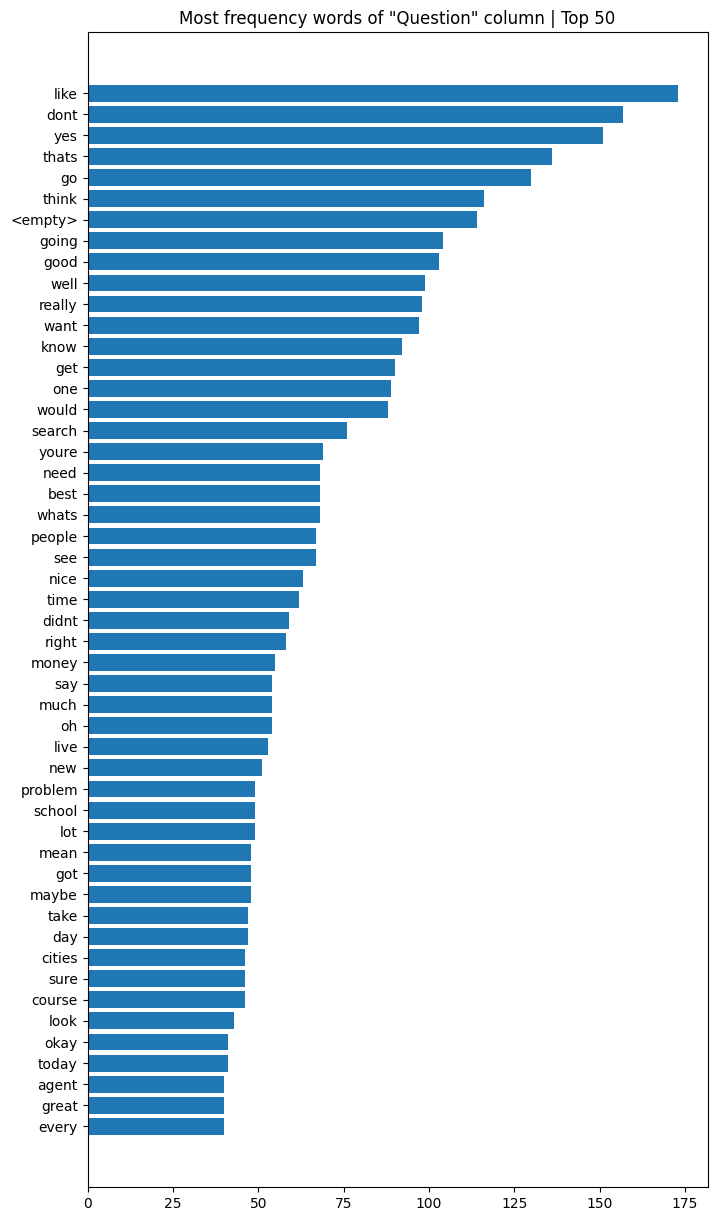

In [574]:
top_words_to_plot = 50

fig, ax = plt.subplots(figsize=(8,15))

top_words = []
top_freqs = []
for idx, (word, freq) in zip(range(top_words_to_plot), question_freq_words.items()):
    top_words.append(word)
    top_freqs.append(freq)
top_words = list(reversed(top_words))
top_freqs = list(reversed(top_freqs))

ax.barh(y=top_words, width=top_freqs)
ax.set_title(label=f'Most frequency words of "Question" column | Top {top_words_to_plot}')

plt.show()

<h4>2.2.2.4 - Filtering word frequency by initial letter</h4>

In [575]:
init_word = 'n'
question_freq_words_by_word = {k: v for k,v in question_freq_words.items() if k.startswith(init_word)}

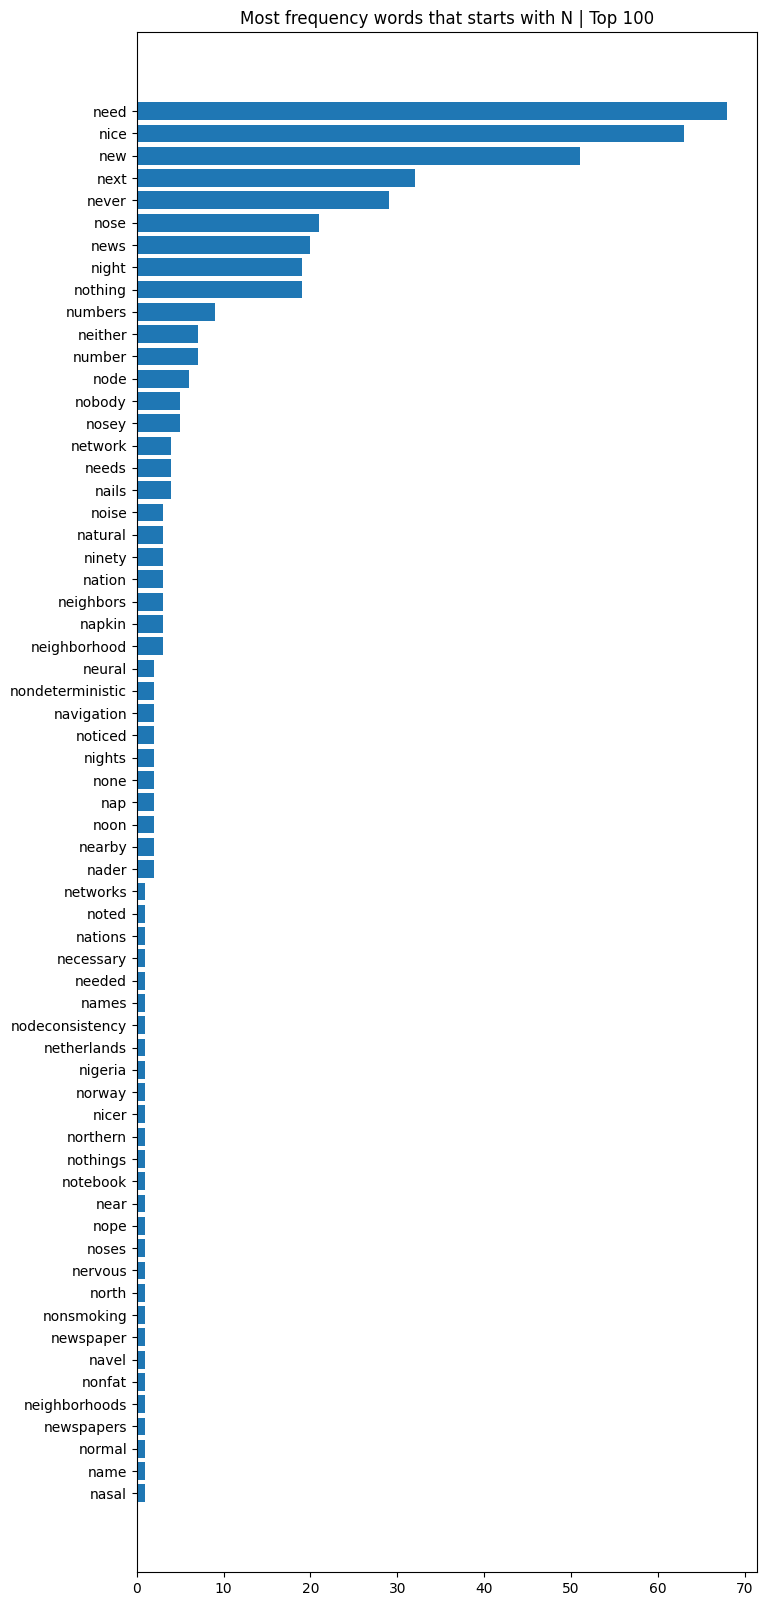

In [576]:
top_words_to_plot = 100

fig, ax = plt.subplots(figsize=(8,20))

top_words = []
top_freqs = []
for idx, (word, freq) in zip(range(top_words_to_plot), question_freq_words_by_word.items()):
    top_words.append(word)
    top_freqs.append(freq)
top_words = list(reversed(top_words))
top_freqs = list(reversed(top_freqs))

ax.barh(y=top_words, width=top_freqs)
ax.set_title(label=f'Most frequency words that starts with {init_word.upper()} | Top {top_words_to_plot}')

plt.show()

<h5>2.2.2.4.1 - Analysing especific word</h5>

In [577]:
target_word = 'norway'
target_sentences = []


for sentence in question_token:
    if target_word in sentence:
        target_sentences.append(' '.join(sentence))

if target_sentences:
    for sentence in target_sentences:
        print(f'{sentence:50}')
else:
    print('No sentence has been found.')

best cities live norway                           


<h4>2.2.2.5 - Plotting word cloud</h4>

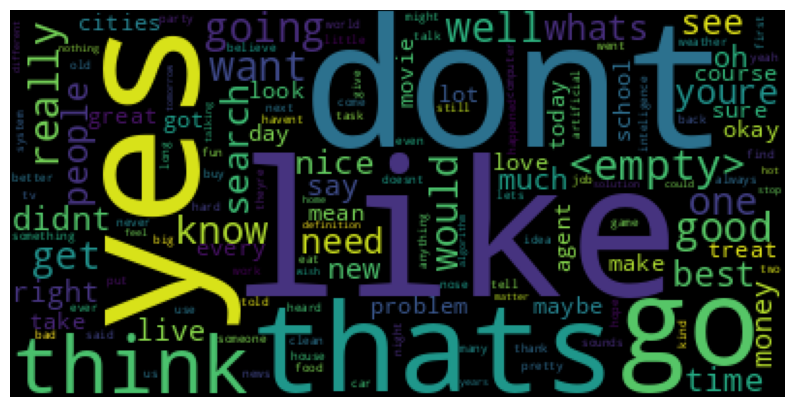

In [578]:
plotWordCloud(question_token)

<h4>2.2.2.6 - Displaying last info about questions</h4>

In [579]:
longest_question = 0

for sentence in question_token:
    if len(sentence) > longest_question:
        longest_question = len(sentence)

question_n_words = len(question_freq_words)

print(f'Number of unique words in question: {question_n_words}')
print(f'Logest question length: {longest_question}')

Number of unique words in question: 3080
Logest question length: 20


<h3>2.2.3 - 'Answer' column</h3>

<h4>2.2.3.1 - Fixinig text</h4>

In [580]:
cleaned_dataset['answers'].clear()
chars_filter = re.compile(pattern=r'''[.]*[(”?,:;"'“*\n\r)ºª!.-]+[.]*''')

replacement = {
    'bluedog123': 'blue dog 123',
    'csp': 'content security policy',
    'cant': 'can not',
    'zerosum': 'zero sum',
    'itll': 'it will',
    'ii': '2',
    'isnt': 'is not',
    'ill': 'i will',
    'id': 'i would',
    'im': 'i am',
    'ive': 'i have',
    'hes': 'he is',
    'shes': 'she is',
    'humanlevel': 'human level',
    'al': 'artificial inteligence',
    'ai': 'artificial inteligence',
    'funnylooking': 'funny looking',
    'dont': 'do not',
    'countrybudapest': 'country budapest',
    'nightlifehiroshima': 'night life hiroshima',
    'nightlifepuerto': 'night life puerto',
    'nightlifetampere': 'night life tampere',
    'nightlifemaribor': 'night life maribor',
    'nightlifebeijing': 'night life beijing',
    'nightlifevalencia': 'night life valencia',
    'nightlifepattaya': 'night life pattaya',
    'nightlifegothenburg': 'night life gothenburg',
    'nightlifeodessa': 'night life odessa',
    'nightlifeflorence': 'night life florence',
    'nightlifekyoto': 'night life kyoto',
    'nightlifebergen': 'night life bergen',
    'nightlifesunshine': 'night life sunshine',
    'nightlifemunich': 'night life munich',
    'nightlifebrno': 'night life brno',
    'nightlifesplit': 'night life split',
    'nightlifeostrava': 'night life ostrava',
    'nightlifedebrecen': 'night life debrecen',
    'nightlifecórdoba': 'night life cordoba',
    'nightlifekošice': 'night life košice',
    'netherlandsamsterdam': 'nether lands amsterdam',
    'nan': '<empty>'
}

In [581]:
answer_token = []
new_sentence = []

for row in tqdm.tqdm(iterable=data_frame['answer'], desc='Tokening "Answer" column..'):
    # normalizing text
    sentence = row.strip().lower()
    # removing stop words
    new_sentence.clear()
    for word in sentence.split(' '):
        curr_word_filter = chars_filter.search(string=word)
        while curr_word_filter:
            word = word.replace(curr_word_filter.group(0), '')
            curr_word_filter = chars_filter.search(string=word)
        if word in replacement:
            word = replacement[word].split(' ')
        if not isinstance(word, list):
            word = [word]
        for w in word:
            if len(w):
                new_sentence.append(w)
    # checking if a sentence is
    # empty
    if not len(new_sentence):
        new_sentence.append('<empty>')
    # saving new sentence
    answer_token.append(new_sentence.copy())
    cleaned_dataset['answers'].append(' '.join(new_sentence))

Tokening "Answer" column..: 100%|██████████| 4353/4353 [00:00<00:00, 62681.07it/s]


<h4>2.2.3.2 - Counting frequency of words</h4>

In [582]:
answer_freq_words = {}

for token in tqdm.tqdm(iterable=answer_token, desc='Counting frequency of words..'):
    for word in token:
        if word not in answer_freq_words:
            answer_freq_words[word] = 0
        answer_freq_words[word] += 1

# sorting by frequency
answer_freq_words = dict(sorted(answer_freq_words.items(), key=lambda x: x[1], reverse=True))

Counting frequency of words..: 100%|██████████| 4353/4353 [00:00<00:00, 559094.97it/s]


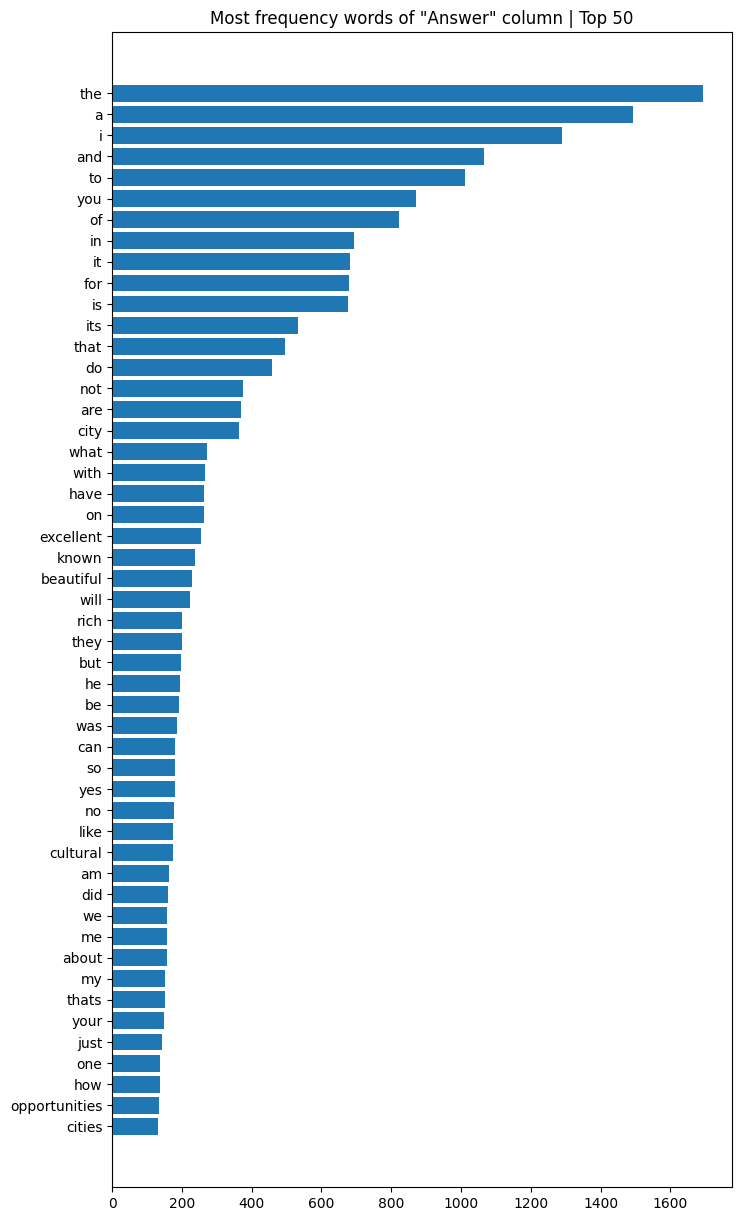

In [583]:
top_words_to_plot = 50

fig, ax = plt.subplots(figsize=(8,15))

top_words = []
top_freqs = []
for idx, (word, freq) in zip(range(top_words_to_plot), answer_freq_words.items()):
    top_words.append(word)
    top_freqs.append(freq)
top_words = list(reversed(top_words))
top_freqs = list(reversed(top_freqs))

ax.barh(y=top_words, width=top_freqs)
ax.set_title(label=f'Most frequency words of "Answer" column | Top {top_words_to_plot}')

plt.show()

<h4>2.2.3.3 - Filtering word frequency by initial letter</h4>

In [584]:
init_word = 'h'
answer_freq_words_by_word = {k: v for k,v in answer_freq_words.items() if k.startswith(init_word)}

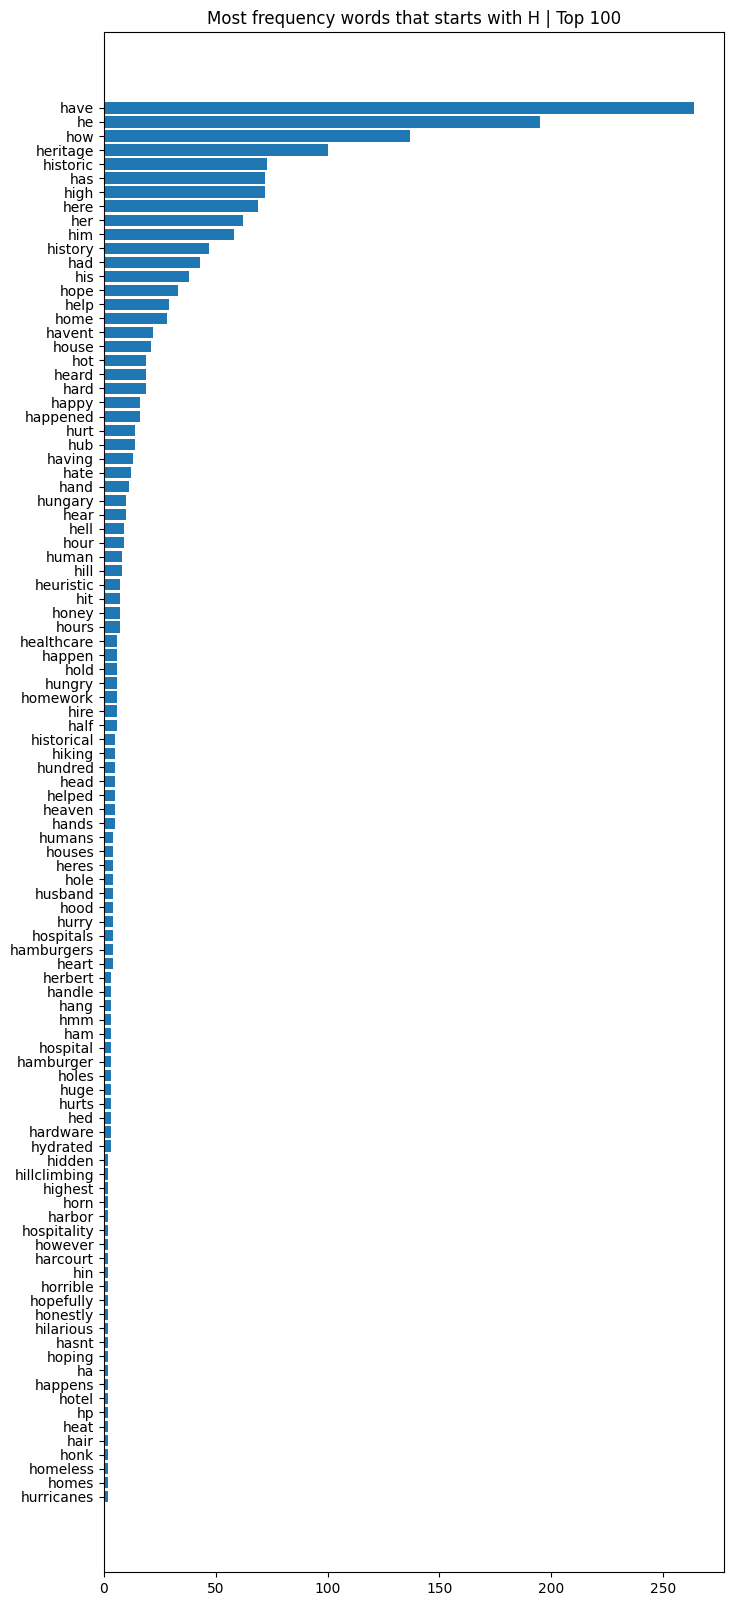

In [585]:
top_words_to_plot = 100

fig, ax = plt.subplots(figsize=(8,20))

top_words = []
top_freqs = []
for idx, (word, freq) in zip(range(top_words_to_plot), answer_freq_words_by_word.items()):
    top_words.append(word)
    top_freqs.append(freq)
top_words = list(reversed(top_words))
top_freqs = list(reversed(top_freqs))

ax.barh(y=top_words, width=top_freqs)
ax.set_title(label=f'Most frequency words that starts with {init_word.upper()} | Top {top_words_to_plot}')

plt.show()

<h5>2.2.3.3.1 - Analysing especific word</h5>

In [586]:
target_word = 'nanny'
target_sentences = []


for sentence in answer_token:
    if target_word in sentence:
        target_sentences.append(' '.join(sentence))

if target_sentences:
    for sentence in target_sentences:
        print(f'{sentence:50}')
else:
    print('No sentence has been found.')

of course she is going to hire a nanny for her eight infants


<h4>2.2.3.4 - Plotting word cloud</h4>

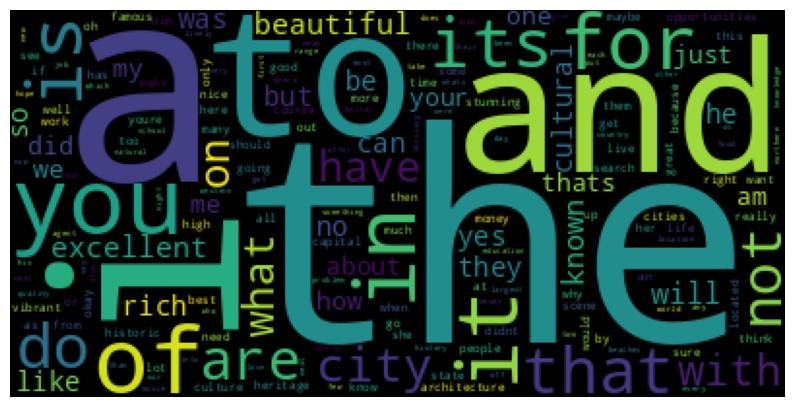

In [587]:
plotWordCloud(answer_token)

<h3>2.2.7 - Creating new dataset</h3>

In [595]:
cleaned_dataframe = pd.DataFrame(data=cleaned_dataset)

In [596]:
cleaned_dataframe.head(10)

,question,answers
0,first work generally recognized artificial int...,warren mcculloch and walter pitts 1943
1,sources drawn formation first work generally r...,knowledge of the basic physiology and function...
2,created hebbian learning rule,donald hebb 1949
3,first neural network built,1950
4,first neural network called,the snarc
5,introduced turing test,machine learning
6,alan turing prefer method creating human level...,he prefer to develop learning algorithms and t...
7,presented logic theorist lt,allen newell and herbert simon from carnegie tech
8,general problem solver gps designed,gps was designed from the start to imitate hum...
9,model robably first program embody thinking hu...,general problem solver gps


<h4>2.2.7.1 - Analysing empty fields</h4>

In [597]:
df_empty = cleaned_dataframe.loc[(cleaned_dataframe['question'] == '<empty>') | (cleaned_dataframe['answers'] == '<empty>')]
print(f'Number of empty fields: {df_empty.shape[0]}')

Number of empty fields: 132


In [598]:
df_empty

,question,answers
13,<empty>,on checkers
37,<empty>,after 1988
78,<empty>,better
616,<empty>,i really love how rain clears the air
697,<empty>,talk to you later
...,...,...
4340,treat poison,<empty>
4341,treat broken teeth,<empty>
4342,treat seizure,<empty>
4343,treat head injury,<empty>


<h4>2.2.7.2 - Dropping empty rows</h4>

In [599]:
cleaned_dataframe.drop(labels=cleaned_dataframe[(cleaned_dataframe['question'] == '<empty>') | (cleaned_dataframe['answers'] == '<empty>')].index, inplace=True)

<h3>2.2.8 - Creating word dict</h3>

In [605]:
word_dict = {
    '<start>': 0,
    '<stop>': 1,
    '<pad>': 2
}

for row in range(cleaned_dataframe.shape[0]):
    question, answer = cleaned_dataframe.iloc[row,:]
    for word in set(question.split(' ') + answer.split(' ')):
        if word not in word_dict:
            word_dict[word] = len(word_dict)

print(f'Number of unique words: {len(word_dict)}')

Number of unique words: 5249
